# RP55 analysis and 2D graphics


The objective of this example is to present problem 55 of the BBRC. We also present graphic elements for the visualization of the limit state surface in 2 dimensions.

The dimension is equal to 2 and the probability is close to $10^{-2}$. This makes this problem relatively easy to solve. The distribution is uniform in the square $[-1,1]^2$. The failure domain is made of 5 diagonal bands. Capturing these bands is relatively easy and a Monte-Carlo simulation perform well in this case. The FORM method cannot perform correctly, since the failure domain cannot be linearized in the gaussian space. Hence, the SORM or FORM-IS methods do not perform satisfactorily.

In [1]:
import openturns as ot
import numpy as np
import otbenchmark as otb
from shapely.geometry import Polygon

In [2]:
problem = otb.ReliabilityProblem55()

In [3]:
print(problem)

name = RP55
event = class=ThresholdEventImplementation antecedent=class=CompositeRandomVector function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x1,x2,gsys] evaluationImplementation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,x2] outputVariablesNames=[gsys] formulas=[var g1 := 0.2 + 0.6 * (x1 - x2)^4 - (x1 - x2) / sqrt(2);var g2 := 0.2 + 0.6 * (x1 - x2)^4 + (x1 - x2) / sqrt(2);var g3 := (x1 - x2) + 5 / sqrt(2) - 2.2;var g4 := (x2 - x1) + 5 / sqrt(2) - 2.2;gsys := min(g1, g2, g3, g4)] gradientImplementation=class=SymbolicGradient name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,x2] outputVariablesNames=[gsys] formulas=[var g1 := 0.2 + 0.6 * (x1 - x2)^4 - (x1 - x2) / sqrt(2);var g2 := 0.2 + 0.6 * (x1 - x2)^4 + (x1 - x2) / sqrt(2);var g3 := (x1 - x2) + 5 / sqrt(2) - 2.2;var g4 := (x2 - x1) + 5 / sqrt(2) - 2.2;gsys := min(g1, g2, g3, g4)] hessianImplementation=class=SymbolicHessia

In [4]:
event = problem.getEvent()
g = event.getFunction()

In [5]:
problem.getProbability()

0.5600144282863704

## Compute the bounds of the domain

In [6]:
inputVector = event.getAntecedent()
distribution = inputVector.getDistribution()
X1 = distribution.getMarginal(0)
X2 = distribution.getMarginal(1)
alphaMin = 0.00001
alphaMax = 1 - alphaMin
lowerBound = ot.Point(
    [X1.computeQuantile(alphaMin)[0], X2.computeQuantile(alphaMin)[0]]
)
upperBound = ot.Point(
    [X1.computeQuantile(alphaMax)[0], X2.computeQuantile(alphaMax)[0]]
)

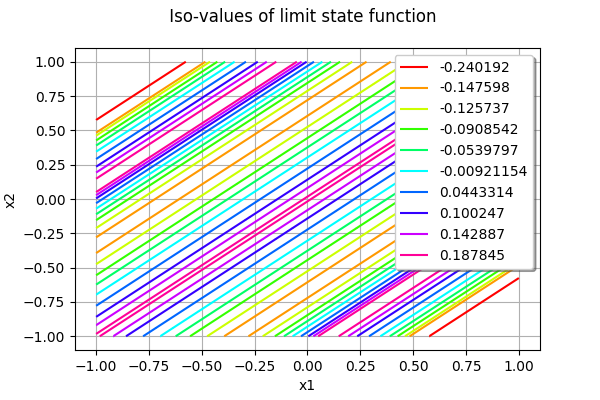

In [7]:
nbPoints = [100, 100]
figure = g.draw(lowerBound, upperBound, nbPoints)
figure.setTitle(" Iso-values of limit state function")
figure

## Print the iso-values of the distribution

/home/osboxes/Documents/venvbbrc/lib/python3.7/site-packages/matplotlib/contour.py:1226: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


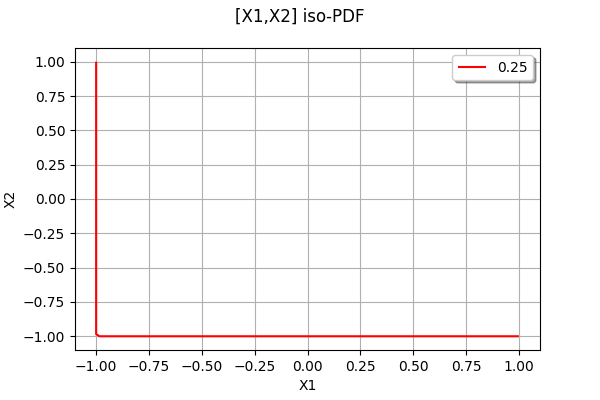

In [8]:
distribution.drawPDF()

In [9]:
sampleSize = 5000
sampleInput = inputVector.getSample(sampleSize)
sampleOutput = g(sampleInput)
drawEvent = otb.DrawEvent(event)

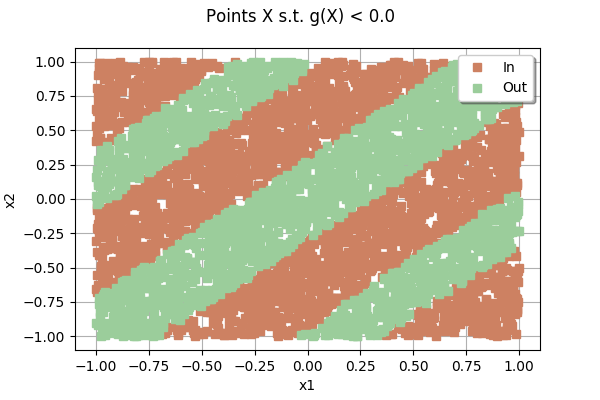

In [10]:
cloud = drawEvent.drawSampleCrossCut(sampleSize)
cloud

## Draw the limit state surface

In [11]:
bounds = ot.Interval(lowerBound, upperBound)
bounds

class=Interval name=Unnamed dimension=2 lower bound=class=Point name=Unnamed dimension=2 values=[-0.99998,-0.99998] upper bound=class=Point name=Unnamed dimension=2 values=[0.99998,0.99998] finite lower bound=[1,1] finite upper bound=[1,1]

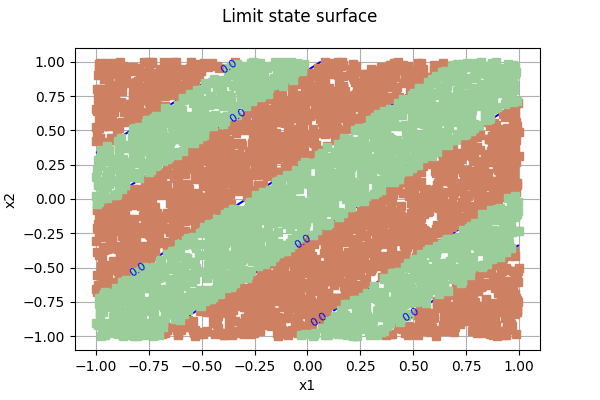

In [12]:
graph = drawEvent.drawLimitStateCrossCut(bounds)
graph.add(cloud)
graph

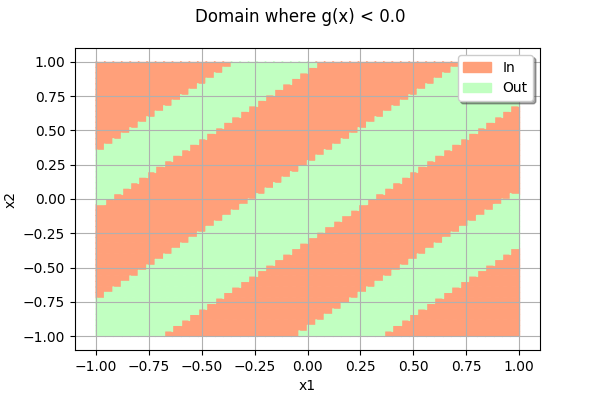

In [13]:
domain = drawEvent.fillEventCrossCut(bounds)
domain

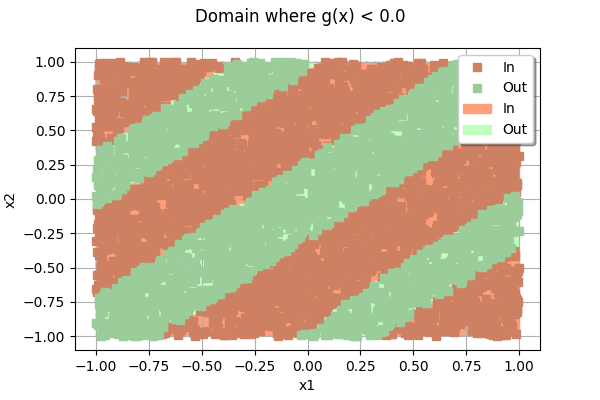

In [14]:
domain.add(cloud)
domain

## Perform Monte-Carlo simulation

In [15]:
algoProb = ot.ProbabilitySimulationAlgorithm(event)
algoProb.setMaximumOuterSampling(1000)
algoProb.setMaximumCoefficientOfVariation(0.01)
algoProb.run()

In [16]:
resultAlgo = algoProb.getResult()
neval = g.getEvaluationCallsNumber()
print("Number of function calls = %d" % (neval))
pf = resultAlgo.getProbabilityEstimate()
print("Failure Probability = %.4f" % (pf))
level = 0.95
c95 = resultAlgo.getConfidenceLength(level)
pmin = pf - 0.5 * c95
pmax = pf + 0.5 * c95
print("%.1f %% confidence interval :[%.4f,%.4f] " % (level * 100, pmin, pmax))

Number of function calls = 43704
Failure Probability = 0.5600
95.0 % confidence interval :[0.5292,0.5908] 


## With FORM-IS

In [17]:
maximumEvaluationNumber = 1000
maximumAbsoluteError = 1.0e-3
maximumRelativeError = 1.0e-3
maximumResidualError = 1.0e-3
maximumConstraintError = 1.0e-3
nearestPointAlgorithm = ot.AbdoRackwitz()
nearestPointAlgorithm.setMaximumEvaluationNumber(maximumEvaluationNumber)
nearestPointAlgorithm.setMaximumAbsoluteError(maximumAbsoluteError)
nearestPointAlgorithm.setMaximumRelativeError(maximumRelativeError)
nearestPointAlgorithm.setMaximumResidualError(maximumResidualError)
nearestPointAlgorithm.setMaximumConstraintError(maximumConstraintError)

In [18]:
metaAlgorithm = otb.ReliabilityBenchmarkMetaAlgorithm(problem)
benchmarkResult = metaAlgorithm.runFORMImportanceSampling(
    nearestPointAlgorithm, maximumOuterSampling=10 ** 5, coefficientOfVariation=0.0
)

In [19]:
print(benchmarkResult.summary())

computedProbability = 0.5609716261066401
exactProbability = 0.5600144282863704
absoluteError = 0.0009571978202697062
numberOfCorrectDigits = 2.7671975154038626
numberOfFunctionEvaluations = 101007
numberOfDigitsPerEvaluation = 2.7396096462659644e-05


## With Quasi-Monte-Carlo

In [20]:
sequence = ot.SobolSequence()
experiment = ot.LowDiscrepancyExperiment(sequence, 1)
experiment.setRandomize(False)

In [21]:
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumOuterSampling(10 ** 3)
algo.setMaximumCoefficientOfVariation(0.0)
algo.setBlockSize(10 ** 3)
algo.run()

In [22]:
result = algo.getResult()
probability = result.getProbabilityEstimate()
print("Pf=", probability)

Pf= 0.5593869999999994


## From integration

In [23]:
interval = ot.Interval([-1.0, -1.0], [1.0, 1.0])
interval

class=Interval name=Unnamed dimension=2 lower bound=class=Point name=Unnamed dimension=2 values=[-1,-1] upper bound=class=Point name=Unnamed dimension=2 values=[1,1] finite lower bound=[1,1] finite upper bound=[1,1]

In [24]:
threshold = event.getThreshold()
threshold

0.0

In [25]:
mean = distribution.getMean()
mean

class=Point name=Unnamed dimension=2 values=[0,0]

In [26]:
def ComputeIntegrandPoint(x):
    """Evaluate the integrand on one single point."""
    y = g(x)
    if y[0] < threshold:
        indicator = 1.0
    else:
        indicator = 0.0
    pdf = distribution.computePDF(x)
    z = [indicator * pdf]
    return z


integrand = ot.PythonFunction(2, 1, ComputeIntegrandPoint)

In [27]:
integrand(mean)

class=Point name=Unnamed dimension=1 values=[0]

In [28]:
dimension = distribution.getDimension()
totalNumberOfPoints = 10 ** 4
numberOfPointsInX = int(totalNumberOfPoints ** (1.0 / dimension))
numberOfPointsInX

100

In [29]:
algoGL = ot.GaussLegendre([numberOfPointsInX] * dimension)
value = algoGL.integrate(integrand, interval)
value

class=Point name=Unnamed dimension=1 values=[0.558822]

In [30]:
def ComputeIntegrandSample(sample):
    """Evaluate the integrand on a sample."""
    indicatorBoolean = np.array(g(sample)) < threshold
    indicator = np.array(indicatorBoolean, float)
    pdf = np.array(distribution.computePDF(sample))
    z = indicator * pdf
    return z

In [31]:
integrandSample = ot.PythonFunction(2, 1, func_sample=ComputeIntegrandSample)

In [32]:
sample = distribution.getSample(5)
integrandSample(sample)

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[y0] data=[[0.25],[0.25],[0.25],[0.25],[0.25]]

In [33]:
integrandSample(mean)

class=Point name=Unnamed dimension=1 values=[0]

In [34]:
dimension = distribution.getDimension()
totalNumberOfPoints = 10 ** 6
numberOfPointsInX = int(totalNumberOfPoints ** (1.0 / dimension))
numberOfPointsInX

1000

In [35]:
discretization = [numberOfPointsInX] * dimension
algoGL = ot.GaussLegendre(discretization)
value = algoGL.integrate(integrandSample, interval)
value

class=Point name=Unnamed dimension=1 values=[0.559983]

## Exact computation

We solve the exact equation:

https://www.wolframalpha.com/input/?i=solve+min%280.2+%2B+0.6+*+%28x+-+y%29%5E4+-+%28x+-+y%29+%2F+sqrt%282%29%2C+0.2+%2B+0.6+*+%28x+-+y%29%5E4+%2B+%28x+-+y%29+%2F+sqrt%282%29%2C+%28x+-+y%29+%2B+5+%2F+sqrt%282%29+-+2.2%2C+%28y+-+x%29+%2B+5+%2F+sqrt%282%29+-+2.2%29+%3D+0

```
solve (x - y) + 5 / sqrt(2) - 22/10 = 0
solve 2/10 + 6/10 * d^4 - d / sqrt(2)
```

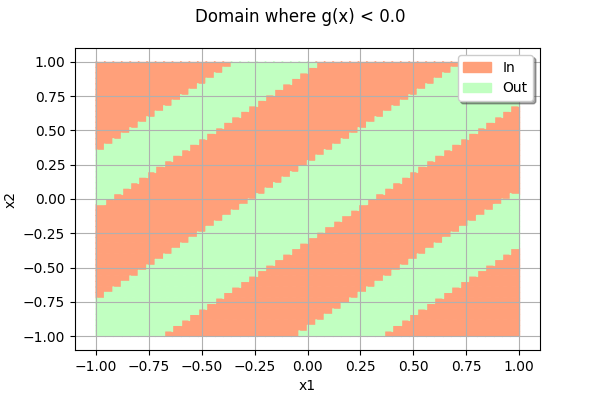

In [36]:
domain = drawEvent.fillEventCrossCut(bounds)
domain

We first compute the exact equations defining the slanted lines at the limit state.

In [37]:
palette = [
    "dodgerblue3",
    "darkorange1",
    "forestgreen",
    "firebrick3",
    "mediumpurple3",
    "lightsalmon4",
    "orchid",
    "gray50",
    "goldenrod3",
    "turquoise3",
]

The goal is to define the failure domain.

In [39]:
root1 = 5.0 / np.sqrt(2.0) - 2.2
root1

1.3355339059327371

In [38]:
root2 = 0.2887406174573670970
root2

0.2887406174573671

In [40]:
root3 = 0.9370483776955247344172976
root3

0.9370483776955247

In [41]:
root2 = 0.2887406174573670970
f1full = ot.SymbolicFunction(["x", "root2"], ["x-root2"])
f1 = ot.ParametricFunction(f1full, [1], [root2])
graph1 = f1.draw(root2 - 1.0, 1.0, 100)
graph1.setColors([palette[0]])
graph1.setLegends(["f1"])

In [42]:
f2full = ot.SymbolicFunction(["x", "root3"], ["x-root3"])
f2 = ot.ParametricFunction(f2full, [1], [root3])
graph2 = f2.draw(root3 - 1.0, 1.0, 100)
graph2.setColors([palette[1]])
graph2.setLegends(["f2"])

In [43]:
f3full = ot.SymbolicFunction(["x", "root1"], ["x-root1"])
f3 = ot.ParametricFunction(f3full, [1], [root1])
graph3 = f3.draw(root1 - 1.0, 1.0, 100)
graph3.setColors([palette[2]])
graph3.setLegends(["f3"])

In [44]:
f4full = ot.SymbolicFunction(["x", "root2"], ["x+root2"])
f4 = ot.ParametricFunction(f4full, [1], [root2])
graph4 = f4.draw(-1.0, 1.0 - root2, 100)
graph4.setColors([palette[3]])
graph4.setLegends(["f4"])

In [45]:
f5full = ot.SymbolicFunction(["x", "root3"], ["x+root3"])
f5 = ot.ParametricFunction(f5full, [1], [root3])
graph5 = f5.draw(-1.0, 1.0 - root3, 100)
graph5.setColors([palette[4]])
graph5.setLegends(["f5"])

In [46]:
f6full = ot.SymbolicFunction(["x", "root1"], ["x+root1"])
f6 = ot.ParametricFunction(f6full, [1], [root1])
graph6 = f6.draw(-1.0, 1.0 - root1, 100)
graph6.setColors([palette[5]])
graph6.setLegends(["f6"])

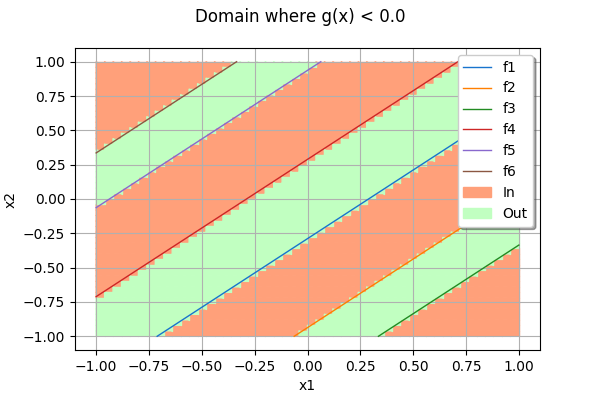

In [47]:
domain.add(graph1)
domain.add(graph2)
domain.add(graph3)
domain.add(graph4)
domain.add(graph5)
domain.add(graph6)
domain

Then we set the corners of the polygons in the failure domain.

In [48]:
data = [
    [-1.0, 1.0],
    [1.0, f1([1.0])[0]],
    [1.0, f2([1.0])[0]],
    [1.0, f3([1.0])[0]],
    [-1.0, f4([-1.0])[0]],
    [-1.0, f5([-1.0])[0]],
    [-1.0, f6([-1.0])[0]],
    [root1 - 1.0, -1.0],
    [root2 - 1.0, -1.0],
    [root3 - 1.0, -1.0],
    [1.0 - root1, 1.0],
    [1.0 - root2, 1.0],
    [1.0 - root3, 1.0],
    [1.0, -1.0],
]
sample = ot.Sample(data)
sample

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=14 dimension=2 data=[[-1,1],[1,0.711259],[1,0.0629516],[1,-0.335534],[-1,-0.711259],[-1,-0.0629516],[-1,0.335534],[0.335534,-1],[-0.711259,-1],[-0.0629516,-1],[-0.335534,1],[0.711259,1],[0.0629516,1],[1,-1]]

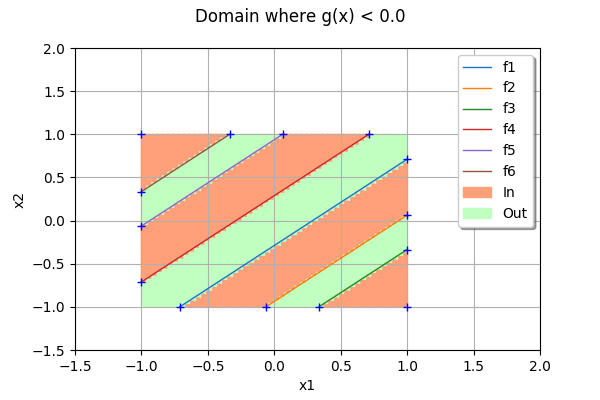

In [49]:
cloud = ot.Cloud(sample)
domain.add(cloud)
extendedBounds = ot.Interval([-1.5, -1.5], [2.0, 2.0])
domain.setBoundingBox(extendedBounds)
domain

In order to identify these points, we add the legends as text in the plot.

In [50]:
texts = ["p" + str(i) for i in range(sample.getSize())]
texts

['p0',
 'p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9',
 'p10',
 'p11',
 'p12',
 'p13']

In [51]:
text = ot.Text(sample, texts)

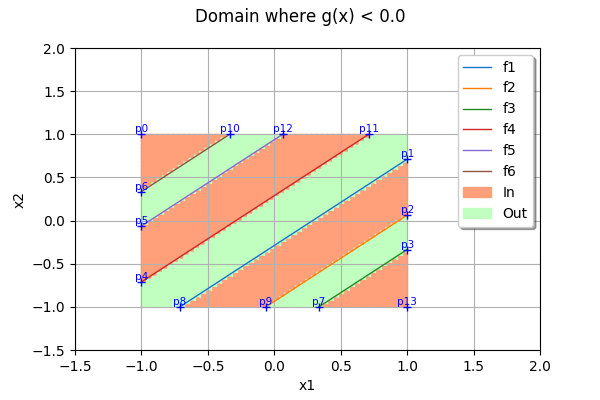

In [52]:
domain.add(text)
domain

The probability is the ratio between the failure domain and the domain itself. The area of the domain is $2^2$. The area of each polygon is computed based on the shapely module.

In [53]:
corners = np.array([sample[i] for i in [0, 6, 10]])
corners

array([[-1.        ,  1.        ],
       [-1.        ,  0.33553391],
       [-0.33553391,  1.        ]])

In [54]:
polygon = Polygon(corners)
area1 = polygon.area
area1

0.2207575950825023

In [55]:
corners = np.array([sample[i] for i in [4, 11, 12, 5]])
corners
polygon = Polygon(corners)
area2 = polygon.area
area2

0.8992712614902384

In [56]:
corners = np.array([sample[i] for i in [8, 9, 2, 1]])
corners
polygon = Polygon(corners)
area3 = polygon.area
area3

0.8992712614902386

In [57]:
corners = np.array([sample[i] for i in [7, 13, 3]])
corners
polygon = Polygon(corners)
area4 = polygon.area
area4

0.2207575950825023

In [58]:
pf = (area1 + area2 + area3 + area4) / 2.0 ** 2
pf

0.5600144282863704

In [59]:
print("pf=%.17e" % (pf))

pf=5.60014428286370380e-01
